# CIFAR10 CNN

Train a simple deep CNN on the CIFAR10 small images dataset.

Some constants we'll use:

In [1]:
batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

In [2]:
from conx import *

dataset = Dataset.get_cifar10()

Using Theano backend.


In [3]:
dataset.summary()

Input Summary:
   count  : 60000 (60000 for training, 0 for testing)
   shape  : (32, 32, 3)
   range  : (0.0, 1.0)
Target Summary:
   count  : 60000 (60000 for training, 0 for testing)
   shape  : (10,)
   range  : (0.0, 1.0)


In [4]:
dataset.split(50000)
dataset.summary()

Input Summary:
   count  : 60000 (50000 for training, 10000 for testing)
   shape  : (32, 32, 3)
   range  : (0.0, 1.0)
Target Summary:
   count  : 60000 (50000 for training, 10000 for testing)
   shape  : (10,)
   range  : (0.0, 1.0)


## Examine Input as Image

In [7]:
import PIL

The internal dataformat:

In [5]:
dataset._inputs[0].shape

(32, 32, 3)

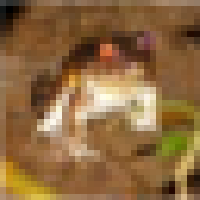

In [6]:
image = PIL.Image.fromarray((dataset._inputs[0] * 255).astype("uint8")).resize((200,200))
image

In [7]:
net = Network("CIRAR10")
net.add(ImageLayer("input", (32, 32), 3)) # depends on K.image_data_format(), right?
net.add(Conv2DLayer("conv1", 32, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv2", 32, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(Conv2DLayer("conv3", 64, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv4", 64, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(FlattenLayer("flatten"))
net.add(Layer("hidden1", 512, activation='relu', vshape=(16, 32), dropout=0.5))
net.add(Layer("output", num_classes, activation='softmax'))
net.connect()

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

net.compile(loss='categorical_crossentropy',
            optimizer=opt)

# Let's train the model using RMSprop
net.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model = net.model

In [8]:
net.set_dataset(dataset)

In [9]:
net.dashboard()

<IPython.core.display.Javascript object>

In [10]:
net.propagate(dataset.inputs[1])

[0.10138512,
 0.097504005,
 0.10180694,
 0.095510878,
 0.1064372,
 0.10266913,
 0.0948999,
 0.10046576,
 0.10080816,
 0.098512918]

## Let Keras Take over from here

In [11]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

In [12]:
import numpy as np

In [13]:
model = net.model
x_train = net.dataset._train_inputs
y_train = net.dataset._train_targets
x_test = net.dataset._test_inputs
y_test = net.dataset._test_targets

In [14]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/200
  25/1562 [..............................] - ETA: 372s - loss: 2.2995 - acc: 0.1275

KeyboardInterrupt: 

In [15]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Model Accuracy = 0.15


KeyboardInterrupt: 